# Requesting a deployed model in the Google Cloud

This notebook assumes that you successfully ran a ZenML Pipeline on the CycleGAN
dataset as found in this CycleGAN tutorial, and that you deployed your model
in the Google Cloud (either through GCAIP or otherwise).

In [1]:
# Imports and version checks
import tensorflow as tf

print(tf.__version__)

2.1.0


In [2]:
import httplib2

print(httplib2.__version__)

0.18.1


Especially the httplib2 dependency is important here, since the prediction code
using the Google API Client requires a version of httplib2 that is rather new
(>= 0.16 should be fine). This example was run with version 0.18.1 of httplib2.

# Building a TFExample from an image and formatting it correctly

First, we point to an image and make a TFExample out of it. The conversion code looks like this:

In [3]:
def prepare_tfexample(image_path):
    """
    Prepares an image into a TFExample understood by the served model.
    """
    with open(image_path, "rb") as img_file:
        real_image_raw = img_file.read()
        real_image = tf.io.decode_image(real_image_raw).numpy()

    label = 1  # our label convention for real images
    height, width, num_channels = real_image.shape

    feature = {
        'height': tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width': tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'num_channels': tf.train.Feature(int64_list=tf.train.Int64List(value=[num_channels])),
        "image": tf.train.Feature(bytes_list=tf.train.BytesList(value=[real_image_raw])),
        "label": tf.train.Feature(int64_list=tf.train.Int64List(value=[label]))
    }

    # return the TFExample
    return tf.train.Example(features=tf.train.Features(feature=feature))

Now point to an example image from the CycleGAN dataset and convert it to a TFExample!

In [19]:
# change this to point to your local image path
image_path = "/Users/nicholasjunge/workspaces/maiot/ce_project/images/0a497f768d.jpg"

example = prepare_tfexample(image_path)

In [5]:
print(example)

features {
  feature {
    key: "height"
    value {
      int64_list {
        value: 256
      }
    }
  }
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\000\000\001\000\001\000\000\377\333\000C\000\010\006\006\007\006\005\010\007\007\007\t\t\010\n\014\024\r\014\013\013\014\031\022\023\017\024\035\032\037\036\035\032\034\034 $.\' \",#\034\034(7),01444\037\'9=82<.342\377\333\000C\001\t\t\t\014\013\014\030\r\r\0302!\034!22222222222222222222222222222222222222222222222222\377\300\000\021\010\001\000\001\000\003\001\"\000\002\021\001\003\021\001\377\304\000\037\000\000\001\005\001\001\001\001\001\001\000\000\000\000\000\000\000\000\001\002\003\004\005\006\007\010\t\n\013\377\304\000\265\020\000\002\001\003\003\002\004\003\005\005\004\004\000\000\001}\001\002\003\000\004\021\005\022!1A\006\023Qa\007\"q\0242\201\221\241\010#B\261\301\025R\321\360$3br\202\t\n\026\027\030\031\032%&\'()*456789:CDEFGHIJSTUVWXYZcdefghijstuvwxy

#### Formatting

Looks good! Now we have to convert it to base64 so that AI Platform can parse the data properly. More information can be found here: https://cloud.google.com/ai-platform/prediction/docs/online-predict 

In [20]:
import base64
instance = {"examples": {"b64": base64.b64encode(example.SerializeToString()).decode("utf-8")}}

# Requesting a prediction from our model

First we point the environment variable GOOGLE_APPLICATION_CREDENTIALS (used frequently by GCP) to our service account.

In [7]:
import os

# change this to point to your service account file
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/Users/nicholasjunge/workspaces/maiot/credentials/maiot-pgo-client.json"

### The actual prediction request code

The following code is used to query our model deployed in AI Platform. It can be found as well on the AI Platform Docs under https://cloud.google.com/ai-platform/prediction/docs/online-predict.

In [8]:
import googleapiclient
def predict_json(project, model, instances, version=None):
    """Send json data to a deployed model for prediction.

    Args:
        project (str): project where the AI Platform Model is deployed.
        model (str): model name.
        instances ([Mapping[str: Any]]): Keys should be the names of Tensors
            your deployed model expects as inputs. Values should be datatypes
            convertible to Tensors, or (potentially nested) lists of datatypes
            convertible to tensors.
        version: str, version of the model to target.
    Returns:
        Mapping[str: any]: dictionary of prediction results defined by the
            model.
    """
    # Create the AI Platform service object.
    # To authenticate set the environment variable
    # GOOGLE_APPLICATION_CREDENTIALS=<path_to_service_account_file>
    service = googleapiclient.discovery.build('ml', 'v1')
    name = 'projects/{}/models/{}'.format(project, model)

    if version is not None:
        name += '/versions/{}'.format(version)

    response = service.projects().predict(
        name=name,
        body={'instances': instances}
    ).execute()

    if 'error' in response:
        raise RuntimeError(response['error'])

    return response['predictions']

In [21]:
# change these to your project and model name
project = "maiot-pgo"
model_name = "model_1b3f58ca50a94ca_0cac48c8_a35d_4_defaultworkspace"

prediction = predict_json(project=project, model=model_name, instances=[instance])

And there we have it! Let us visualize the response right away, along with our original image to look at the style transfer done by our model.

In [22]:
import numpy as np
predicted_image = np.array(prediction[0]['output_0'])

predicted_image.shape

(256, 256, 3)

In [23]:
with open(image_path, "rb") as img_file:
    real_image_raw = img_file.read()
    real_image = tf.io.decode_image(real_image_raw).numpy()

## Head-to-head comparison

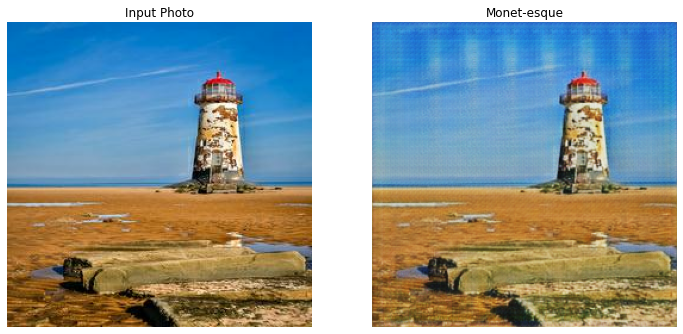

In [24]:
import matplotlib.pyplot as plt
_, ax = plt.subplots(1, 2, figsize=(12, 12))

predicted_image_revert = (predicted_image * 127.5 + 127.5).astype(np.uint8)

ax[0].imshow(real_image)
ax[1].imshow(predicted_image_revert)
ax[0].set_title("Input Photo")
ax[1].set_title("Monet-esque")
ax[0].axis("off")
ax[1].axis("off")
plt.show()

It definitely looks different from our input image. If you are unhappy with your results, consider training the model further - GANs are rather infamous for exhibiting convergence issues and can take a long time to train sufficiently. Thanks for trying out this tutorial!